In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna.integration.lightgbm as lgbo
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap
import seaborn as sns

DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/ncaam-march-mania-2021'

# load JS visualization code to notebook
shap.initjs()

In [475]:
train = pd.read_csv(DIR_PATH+'/tourney.csv')
test = pd.read_csv(DIR_PATH+'/test.csv')

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)
X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f<br>
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html<br>
https://hackerdemy.com/2020/09/15/lightgbm-classification/<br>
https://zenn.dev/mosamosa/articles/07d0076c9292136a3639<br>

In [476]:
# パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f
# -------------------現状のベストパラメータ保管場所------------------
# 候補1 : スコア：0.26271, cv mean : 0.5740, 使用特徴量：seed情報無し, kfold=10
best_lgb_params1 = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 128,
              'feature_fraction': 0.6,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.05,
              'max_bin':600,
              'seed':2021
}
# 候補2 : スコア：0.21964, cv mean : 0.5831, 使用特徴量：seed情報無し, kfold=10
best_lgb_params2 = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 1024,
              'feature_fraction': 0.6,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.05,
              'max_bin':600,
              'seed':2021,
              'min_data_in_leaf':15
}
# 候補3(というかほぼほぼこっち): スコア: 0.52239, cv mean:0.5406, kfold=10
best_lgb_params3 = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 1000,
              'max_depth': 15,
              'feature_fraction': 0.3,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.01,
              'max_bin':125,
              'seed':2021,
              'min_data_in_leaf':13,
              'lambda_l1': 2.5,
              'extra_trees': True,
              'num_iterations':10000
}

# -------------------色々パラメータで遊んで精度見てみる場所------------------
# lgb_params = {'objective': 'binary',
#               'metric': 'binary_logloss',
#               'boosting': 'gbdt',
#               'num_leaves': 23,
#               'max_depth' : 5,
#               'max_bin' : 600,
#               'min_sum_hessian_in_leaf' : 1e-5,
#               'feature_fraction': 0.8,
#               'bagging_fraction': 0.6,
#               'bagging_freq': 5,
#               'learning_rate': 0.05,
#               'num_iterations' : 5000,
#               'random_state' : 42
#              }

lgb_params = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 1000,
              'max_depth': 15,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.01,
              'max_bin':125,
              'seed':2021,
              'min_data_in_leaf':13,
              'lambda_l1': 2.5,
              'extra_trees': True,
              'num_iterations':10000
}

def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred=np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
    
        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  #categorical_feature=list(cate_ft_lst),
                  )

        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])
        

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)
    
    
    if plt_iter:
        
        fig, axs = plt.subplots(5, 2, figsize=(9,20))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

###### fold 1 ######


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.668876	valid_1's binary_logloss: 0.675846
[40]	training's binary_logloss: 0.650286	valid_1's binary_logloss: 0.662873
[60]	training's binary_logloss: 0.635438	valid_1's binary_logloss: 0.652774
[80]	training's binary_loglo

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.668645	valid_1's binary_logloss: 0.673825
[40]	training's binary_logloss: 0.65039	valid_1's binary_logloss: 0.659254
[60]	training's binary_logloss: 0.635533	valid_1's binary_logloss: 0.648545
[80]	training's binary_loglos

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.669778	valid_1's binary_logloss: 0.674011
[40]	training's binary_logloss: 0.651607	valid_1's binary_logloss: 0.65848
[60]	training's binary_logloss: 0.636729	valid_1's binary_logloss: 0.646343
[80]	training's binary_loglos

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.668985	valid_1's binary_logloss: 0.676042
[40]	training's binary_logloss: 0.649957	valid_1's binary_logloss: 0.663571
[60]	training's binary_logloss: 0.634249	valid_1's binary_logloss: 0.654891
[80]	training's binary_loglo

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.668407	valid_1's binary_logloss: 0.667895
[40]	training's binary_logloss: 0.651266	valid_1's binary_logloss: 0.649469
[60]	training's binary_logloss: 0.63704	valid_1's binary_logloss: 0.635123
[80]	training's binary_loglos

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.670574	valid_1's binary_logloss: 0.667978
[40]	training's binary_logloss: 0.653722	valid_1's binary_logloss: 0.647053
[60]	training's binary_logloss: 0.639689	valid_1's binary_logloss: 0.632461
[80]	training's binary_loglo

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.669958	valid_1's binary_logloss: 0.670953
[40]	training's binary_logloss: 0.651535	valid_1's binary_logloss: 0.653696
[60]	training's binary_logloss: 0.636775	valid_1's binary_logloss: 0.639354
[80]	training's binary_loglo

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.669991	valid_1's binary_logloss: 0.669621
[40]	training's binary_logloss: 0.652219	valid_1's binary_logloss: 0.653733
[60]	training's binary_logloss: 0.638591	valid_1's binary_logloss: 0.640726
[80]	training's binary_loglo

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.670339	valid_1's binary_logloss: 0.673677
[40]	training's binary_logloss: 0.651773	valid_1's binary_logloss: 0.6597
[60]	training's binary_logloss: 0.637255	valid_1's binary_logloss: 0.64875
[80]	training's binary_logloss:

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=2.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.668967	valid_1's binary_logloss: 0.664242
[40]	training's binary_logloss: 0.651311	valid_1's binary_logloss: 0.644288
[60]	training's binary_logloss: 0.637201	valid_1's binary_logloss: 0.628609
[80]	training's binary_loglo

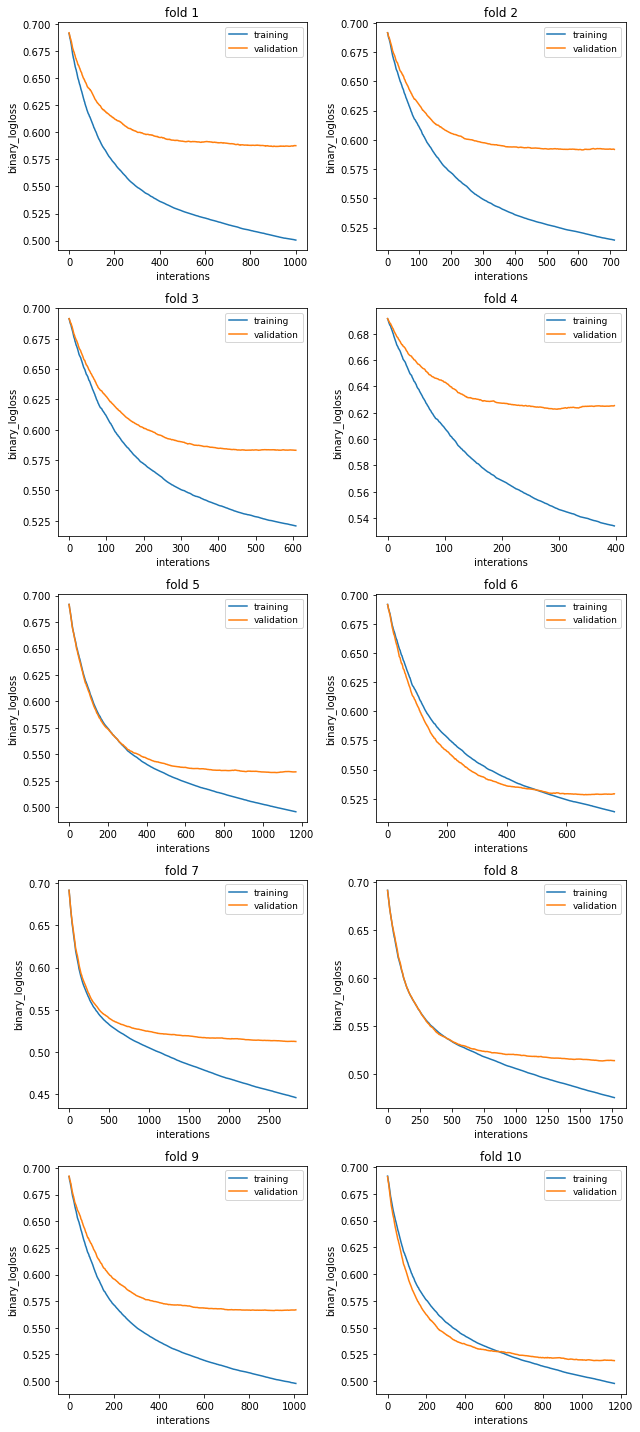

### CV scores by fold ###
fold 1: 0.5870
fold 2: 0.5913
fold 3: 0.5831
fold 4: 0.6227
fold 5: 0.5328
fold 6: 0.5285
fold 7: 0.5126
fold 8: 0.5135
fold 9: 0.5661
fold 10: 0.5193
CV mean score: 0.5557, std: 0.0372.
CPU times: user 46.3 s, sys: 18.7 s, total: 1min 5s
Wall time: 39.9 s


In [477]:
%%time
group_kfold = GroupKFold(n_splits=10)

feature_importance, test_pred = \
    model_training(X, y, group_kfold, s, lgb_params, 
    'binary_logloss', early_stopping=100, plt_iter=True, X_test=X_test)

In [472]:
# plt.figure(figsize=(10, 10));
# sns.barplot(x="importance", y="feature", data=feature_importance)
# plt.title('Feature Importnace')

In [473]:
MSampleSubmission = pd.read_csv(DIR_PATH+'/MSampleSubmissionStage1.csv')

In [474]:
idx = test_pred.shape[0] // 2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('submission_lgbm.csv', index=False)
sub.head()

,ID,Pred
0,2015_1107_1112,0.063608
1,2015_1107_1116,0.158383
2,2015_1107_1124,0.144924
3,2015_1107_1125,0.512428
4,2015_1107_1129,0.286249
